<h1>Classification</h1>

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

<h2 align="center">Random Forests</h2><h3>Parameters study</h3>

In [20]:
from numpy import array, ndarray
import numpy as np
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

np.random.seed(42)

def undersample(X, y):
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]
    num_samples_to_keep = len(indices_class_1)
    selected_indices_class_0 = np.random.choice(indices_class_0, num_samples_to_keep, replace=False)
    selected_indices = np.concatenate([selected_indices_class_0, indices_class_1])
    np.random.shuffle(selected_indices)
    X_undersampled = X[selected_indices]
    y_undersampled = y[selected_indices]
    return X_undersampled, y_undersampled

file_tag = "health"
train_filename = "./../../../data/class_covid_final_train.csv"
test_filename = "./../../../data/class_covid_final_test.csv"
target = "CovidPos"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

trnX, trnY = undersample(trnX, trnY)

#trnX = trnX[:100]
#tstX = tstX[:100]
#trnY = trnY[:100]
#tstY = tstY[:100]
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")
print(len(trnY[trnY == 1]), len(trnY[trnY == 0]))

Train#=155228 Test#=114280
Labels=[0. 1.]
77614 77614


In [21]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

fullX = np.concatenate([trnX, tstX])
fullY = np.concatenate([trnY, tstY])
test_fold = [-1] * len(trnX) + [0] * len(tstX)
cv = PredefinedSplit(test_fold)
for i, (train_index, test_index) in enumerate(cv.split()):
    print(f"Fold {i}")
    print(f"  Train: {len(train_index)=}")
    print(f"  Test: {len(test_index)=}")

Fold 0
  Train: len(train_index)=155228
  Test: len(test_index)=114280


In [22]:
nr_max_trees = 100
lag = 20
n_estimators = list(range(1, nr_max_trees + 1, lag))
max_depths = [2, 5, 7]
max_features = [0.1, 0.4, 0.8, 1.0]

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depths,
    "max_features": max_features
}
print(param_grid)

clf = RandomForestClassifier(n_jobs=4)
search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=cv, verbose=10, return_train_score=False)
search.fit(fullX, fullY)

{'n_estimators': [1, 21, 41, 61, 81], 'max_depth': [2, 5, 7], 'max_features': [0.1, 0.4, 0.8, 1.0]}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
[CV 1/1; 1/60] START max_depth=2, max_features=0.1, n_estimators=1..............
[CV 1/1; 1/60] END max_depth=2, max_features=0.1, n_estimators=1;, score=0.572 total time=   0.1s
[CV 1/1; 2/60] START max_depth=2, max_features=0.1, n_estimators=21.............
[CV 1/1; 2/60] END max_depth=2, max_features=0.1, n_estimators=21;, score=0.590 total time=   0.4s
[CV 1/1; 3/60] START max_depth=2, max_features=0.1, n_estimators=41.............
[CV 1/1; 3/60] END max_depth=2, max_features=0.1, n_estimators=41;, score=0.582 total time=   0.7s
[CV 1/1; 4/60] START max_depth=2, max_features=0.1, n_estimators=61.............
[CV 1/1; 4/60] END max_depth=2, max_features=0.1, n_estimators=61;, score=0.580 total time=   0.9s
[CV 1/1; 5/60] START max_depth=2, max_features=0.1, n_estimators=81.............
[CV 1/1; 5/60] END max_depth=2, max_fea

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(n_jobs=4),
             param_grid={'max_depth': [2, 5, 7],
                         'max_features': [0.1, 0.4, 0.8, 1.0],
                         'n_estimators': [1, 21, 41, 61, 81]},
             scoring='accuracy', verbose=10)

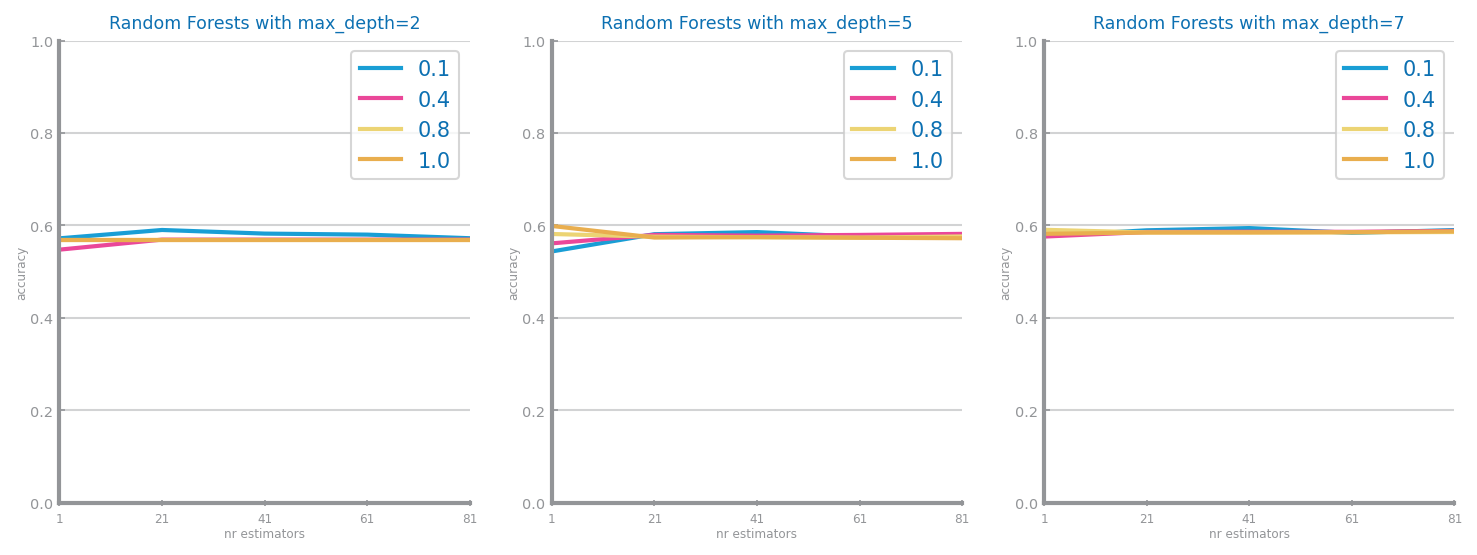

In [23]:
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
results_df.to_csv("./health_forests_results.csv")
# results_df = pd.read_csv("./health_forests_results.csv")

cols: int = len(max_depths)
_, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
for i, max_depth in enumerate(max_depths):
  results = results_df[results_df["param_max_depth"] == max_depth]
  results = results[["param_max_features", "param_n_estimators", "split0_test_score" ]]

  values = {}
  for max_feature, group in results.groupby("param_max_features"):
    scores = [group[group["param_n_estimators"] == n_estimator]["split0_test_score"].values[0] for n_estimator in n_estimators]
    values[max_feature] = scores

  plot_multiline_chart(
      n_estimators,
      values,
      ax=axs[0, i],
      title=f"Random Forests with max_depth={max_depth}",
      xlabel="nr estimators",
      ylabel="accuracy",
      percentage=True,
  )

savefig(f"images/{file_tag}_rf_{eval_metric}_study.png", bbox_inches="tight")
show()

In [24]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_fit_time,60.0,3.094320,3.233332,0.072307,0.569413,1.858685,4.498869,13.992862
std_fit_time,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_score_time,60.0,0.125546,0.079876,0.013062,0.062968,0.120821,0.191343,0.324063
std_score_time,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
split0_test_score,60.0,0.577199,0.009919,0.543507,0.569102,0.576728,0.584737,0.598644
mean_test_score,60.0,0.577199,0.009919,0.543507,0.569102,0.576728,0.584737,0.598644
std_test_score,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rank_test_score,60.0,28.983333,15.720538,1.000000,15.750000,30.500000,44.000000,60.000000


In [25]:
best_model_index = results_df["split0_test_score"].idxmax()
print(results_df.loc[best_model_index])
best_params = results_df.loc[best_model_index]["params"]

print(best_params)
#import ast
#best_params = ast.literal_eval(best_params)
best_model = RandomForestClassifier(n_jobs=-1, **best_params)
best_model.fit(trnX, trnY)

mean_fit_time                                                  0.322123
std_fit_time                                                        0.0
mean_score_time                                                0.018519
std_score_time                                                      0.0
param_max_depth                                                       5
param_max_features                                                  1.0
param_n_estimators                                                    1
params                {'max_depth': 5, 'max_features': 1.0, 'n_estim...
split0_test_score                                              0.598644
mean_test_score                                                0.598644
std_test_score                                                      0.0
rank_test_score                                                       1
Name: 35, dtype: object
{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 1}


RandomForestClassifier(max_depth=5, max_features=1.0, n_estimators=1, n_jobs=-1)

In [26]:
best_model.fit(trnX, trnY)

RandomForestClassifier(max_depth=5, max_features=1.0, n_estimators=1, n_jobs=-1)

<Figure size 600x450 with 0 Axes>

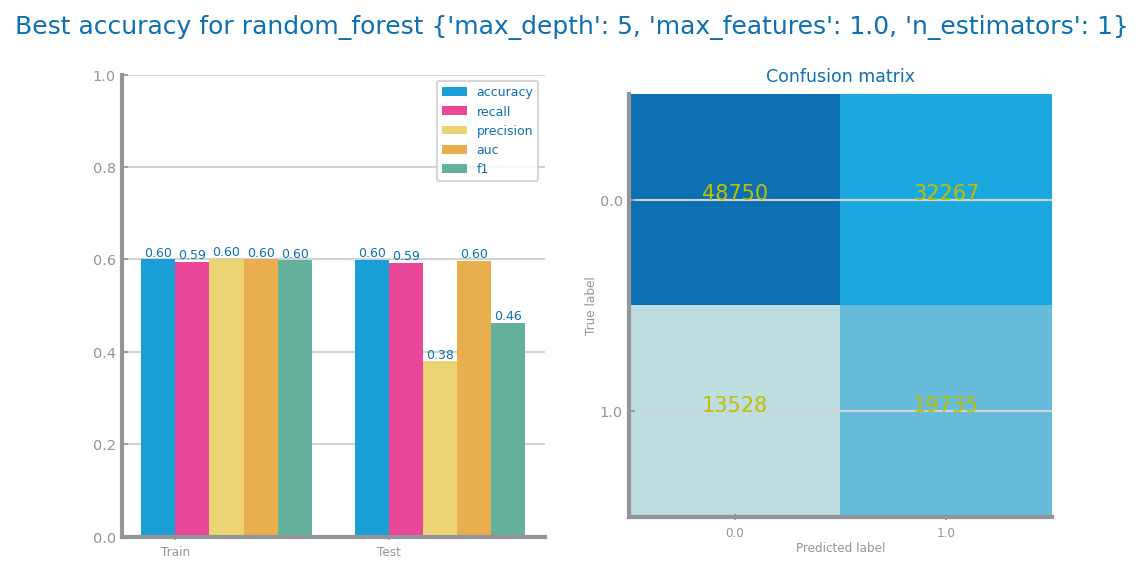

In [27]:

params = {"params": best_params, "metric": "accuracy", "name": "random_forest"}
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. AgeCategory (0.716132027407708)
2. PhysicalHealthDays (0.10425585839074235)
3. SmokerStatus (0.06657004785548598)
4. State (0.03319728218360529)
5. LastCheckupTime (0.02356345213254489)
6. BMI (0.01863254169420364)
7. ChestScan (0.01294717129973165)
8. WeightInKilograms (0.006426860096939427)
9. DifficultyWalking (0.0057597266630926335)
10. DifficultyErrands (0.00560224998812251)
11. RaceEthnicityCategory (0.004874858163120785)
12. Sex (0.002037924124702968)
13. TetanusLast10Tdap (0.0)
14. HighRiskLastYear (0.0)
15. PneumoVaxEver (0.0)
16. AlcoholDrinkers (0.0)
17. HIVTesting (0.0)
18. FluVaxLast12 (0.0)
19. BlindOrVisionDifficulty (0.0)
20. ECigaretteUsage (0.0)
21. DifficultyDressingBathing (0.0)
22. DifficultyConcentrating (0.0)
23. HeightInMeters (0.0)
24. HadKidneyDisease (0.0)
25. HadArthritis (0.0)
26. HadDiabetes (0.0)
27. DeafOrHardOfHearing (0.0)
28. HadDepressiveDisorder (0.0)
29. HadCOPD (0.0)
30. HadSkinCancer (0.0)
31. HadAsthma (0.0)
32. RemovedTeeth (0.0)
33. HadHear

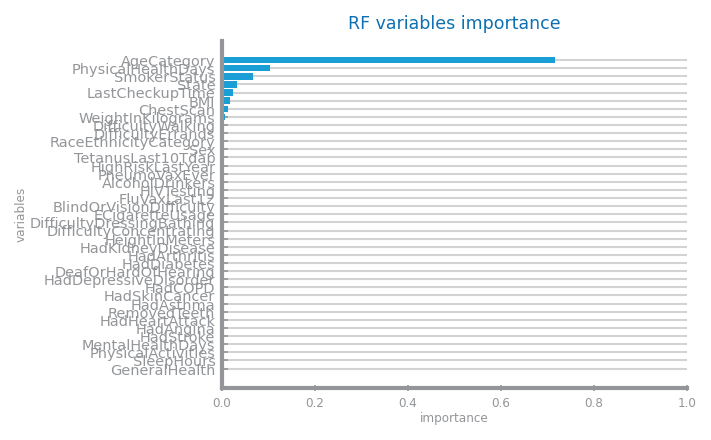

In [28]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png", bbox_inches="tight")

<h3>Overfitting study</h3>

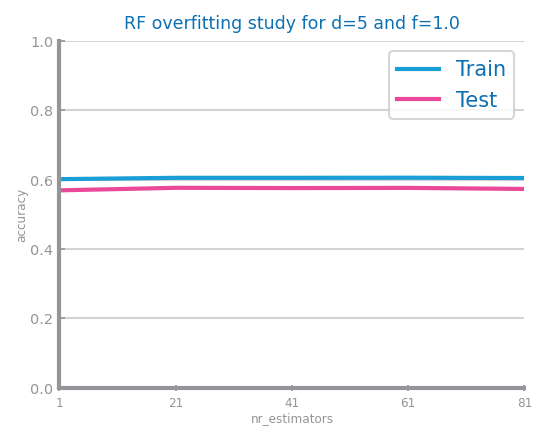

In [29]:
d_max: int = best_params["max_depth"]
feat: float = best_params["max_features"]
nr_estimators: list[int] = list(range(1, nr_max_trees + 1, lag))

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")